Recap: Building micrograd

The purpose of this is to see whether I can "from scratch" build the micrograd engine that Karpathy presented in his lecture that I followed. 

Neural networks are mathematical expressions. Mathematical expressions consist of values and operations. We want to be able to build progressively more complex mathematical expressions and do backpropagation on them. To do so, we'll need our values to be "tied" together somehow in a computational graph. Each value needs to remeber what operation led to it and the values it came from. Once we have that, we can do backpropagation via successively / recursively multiplying local derivatives back acorss the graph.  

a Value is a wrapper around basic python objects (ints, floats, etc)

In [1]:
class Value:
    def __init__(self, data):
        # a value object stores some data
        self.data = data
    # and print out the value for us
    def __repr__(self):
        return f'Value: {self.data}'

In [2]:
a = Value(4.0)
a

Value: 4.0

We need to be able to do math operations on it:

In [3]:
class Value:
    def __init__(self, data):
        self.data = data
    def __repr__(self):
        return f"Value: {self.data}"
    
    def __add__(self, other):
        return Value(self.data + other.data)

In [4]:
a = Value(4.0)
b = Value(5.0)
a+b

Value: 9.0

In [5]:
4 + a

TypeError: unsupported operand type(s) for +: 'int' and 'Value'

In [6]:
# Enable this
class Value:
    def __init__(self, data):
        self.data = data
    def __repr__(self):
        return f"Value:{self.data}"
    def __add__(self, other):
        return Value(self.data + other)
    def __radd__(self, other):
        return self + other

In [7]:
4 + Value(4.0)

Value:8.0

In [8]:
# Let's add multiply 
class Value:
    def __init__(self, data):
        self.data = data
    def __repr__(self):
        return f"Value:{self.data}"
    def __add__(self, other):
        return Value(self.data + other)
    def __mul__(self, other):
        return Value(self.data * other)
    def __radd__(self, other):
        return self + other
    def __rmul__(self, other):
        return self * other

In [9]:
a = Value(2.0)
3 * a

Value:6.0

In [10]:
4 + a

Value:6.0

Now we can start building math expressions in computational graphs. We need to first remeber where each node came from and the formative operation.

In [11]:
class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        
    def __repr__(self):
        return f"Value:{self.data}"
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')
    
    def __radd__(self, other):
        return self + other
    def __rmul__(self, other):
        return self * other

In [12]:
a = Value(4.0)
b = Value(3.0) 
c = Value(5.0)


d = a + b * c 
d

Value:19.0

In [13]:
a._prev

set()

In [14]:
d._prev

{Value:15.0, Value:4.0}

In [15]:
class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        
    def __repr__(self):
        return f"Value:{self.data}"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
    def __radd__(self, other):
        return self + other
    def __rmul__(self, other):
        return self * other

In [16]:
a = Value(4.0)
b = Value(3.0) 
c = Value(5.0)

e = b * c
d = a + e
d

Value:19.0

In [17]:
d._prev, d._op

({Value:15.0, Value:4.0}, '+')

In [18]:
e._prev, e._op

({Value:3.0, Value:5.0}, '*')

How to do backpropagation? 

- Locally, each object will be the result of one math operation. 
- We'll provide each math operation with a `_backward` function corresponding to it. This will be saved in an attribute `backward`.
- We'll also need to store the computed derivative in attribute we call `grad`. All grads initialized to 0.

So, when we call `_backward` on some node, it needs to compute its derivative w.r.t the nodes that formed it, and multiply that with whatever its own gradient to propagate the result to its predecessors.

Addition as example:

consider $out = b + c $.

`out` is a new node that might have gradients w.r.t something after it (or default to 0.0).

as for `b` and `c`: 

We know from rules of calculus:

$ \frac{dout}{db} = 1.0 + 0.0 = 1.0 $

$ \frac{dout}{dc} = 0.0 + 1.0 = 1.0 $

We need to propagate the gradient of `out` by multiplying it with these locally computed gradients and the results become the gradients of `self` & `other` (w.r.t some final node). 

In [19]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda : None
        self.grad = 0.0
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        # its forward pass
        out = Value(self.data + other.data, (self, other), '+')
        
        # its backprop
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        return self + other
    def __rmul__(self, other):
        return self * other    

In [20]:
a = Value(4.0)
b = Value(3.0) 
c = Value(5.0)

e = b * c
d = a + e
d

Value(data=19.0)

In [21]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

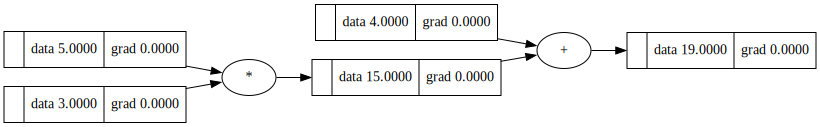

In [22]:
draw_dot(d)

In [23]:
d.grad = 1.0
d._backward()
e._backward()
a._backward()

In [24]:
# adjust the code to make sure math operations work with non-Value objects
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda : None
        self.grad = 0.0
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        # its forward pass
        out = Value(self.data + other.data, (self, other), '+')
        
        # its backprop
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        return self + other
    def __rmul__(self, other):
        return self * other    

In [25]:
4.0 + Value(5.0)

Value(data=9.0)

Next steps: 
1. We need to extend the mathematical functionalities our value objects are capable of: eg subtract, divide, exponentiate (power), tanh - obviously providing them with backprop functions as well.
2. We need to be able to take one node and call backpropagation on it such that it backpropagates to its origin (to the beginning of its math expression). Since each node points to its predecessors, we achieve this by accumulating a list of all nodes using a topological sorting algorithm (such that we have nodes ordered as they will be on the graph from left to right) then we call `._backward` in a loop on each one. 

In [26]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [477]:
# add the math functions
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
        #grdient stuff
        self._backward = lambda: None
        self.grad = 0.0
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    #math operations
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # make sure we add similar objects
        out = Value(self.data + other.data, (self, other), '+') # forward pass
        '''
        def _backward(): #backward pass
            self.grad += 1.0 * out.grad # dout / dself * out.grad
            other.data += 1.0 * out.grad ---> STUPID BUG
        out._backward = _backward # save the function in the object to be called when needed
        '''
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
        
    

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*') #forward pass
        
        def _backward():
            self.grad += other.data * out.grad # dout/dself * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __neg__(self): # we'll define negation to use in subtraction
        return self * -1
    def __sub__(self, other): # we define subtraction as addition + (-num)
        return self + (-other)
    


    def __pow__(self, other):
        assert isinstance(other, (int, float)) #support only int and float powers for now
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward(): # use the power rule from calculus d(X^n) = n * X^(n-1)
            self.grad += other * (self.data ** (other - 1)) * out.grad # as always we propagate the loca out grad
        out._backward = _backward
        
        return out


    def __truediv__(self, other): # we implement division as multiplication by denominator^-1
        return self * other**-1



    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out


    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
            
        return out

    # the reverse operations 
    def __radd__(self, other):
        return self + other
    def __rmul__(self, other):
        return self * other
    
    # then we implement backward by using topological sort
    def backward(self):
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [478]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'

In [479]:
o.backward()

In [480]:
#draw_dot(o)

We now have the autograd engine. An wrapper around Python's own scalar math objects which is able to record a graph (acyclic) of all the operations performed on a value and be able to later to backpropagation on this computational graph.

Now we have this, can we make neurons and neural networks? 
We'll divide this into:
- Make a Neuron
- Make a Layer (of Neurons)
- Make a Network (MLP: Multi-Layer Perceptron in this example)

What's a Neuron?

A neuron has weights (synapses), bias and incoming data (not part of it). It does dot product of weights and data, pass them through non-linearity to produce output.

In [481]:
class Neuron:
    def __init__(self, nin): #nin: number of inputs
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] #initialize random w = num incoming
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x): # we need to be able to call the neuron on incoming data and it does dot product and non-lin
        act = sum((xi*wi for xi, wi in zip(x, self.w)), self.b)
        out = act.tanh()
        return out
    
    # and give it the ability to accumulate its parameters so we can call backward() on them
    def parameters(self):
        return self.w + [self.b]

In [482]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=0.9893073616790083)

In [483]:
n.parameters()

[Value(data=0.2157556374298477),
 Value(data=0.9983618799694451),
 Value(data=-0.8136037645801355)]

What is a Layer?

- A Layer is a bunch of neurons - not connected to one another - but may receive the same input.
- Each neuron in the layer has number of inputs (nin) (decide the number of its synapses / weights).
- Each neuron itself repreents an output of the layer so the number of neurons in the layer is nout

In [484]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    # parameters will be a list of weights and biases for each neuron
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [485]:
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=0.992105490858516),
 Value(data=-0.6451328743937788),
 Value(data=0.9783653343037416)]

In [486]:
n.parameters()

[Value(data=0.7303001274402317),
 Value(data=0.33907302340156753),
 Value(data=0.2875706356975678),
 Value(data=-0.5335542706067831),
 Value(data=0.24217783289780237),
 Value(data=-0.42634146213079616),
 Value(data=0.8819639248654263),
 Value(data=0.14895287290391646),
 Value(data=0.047078167755747025)]

And finally, a MLP is a bunch of layers where one layer's output is the next layer's input (a bunch of layers connected to one another sequentially).

We'll use it as:

Layer(3, [4,4,1]): means a 3 layer MLP with 4 neurons in L1, 4 in L2 and 1 in L3.

- L1 : 3 synapses/n, 4 neurons
- L2 : 4 synapses/n, 4 neurons
- L3 : 4 synapses/n, 1 neuron

In [487]:
class MLP:
    def __init__(self, nin, nouts): #nouts is the number of neurons in each layer (the list)
        # each layer will need nin, nout (synapses and neurons) 
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i, _ in enumerate(nouts)]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    # same as before:
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [488]:
x = [2.0, 3.0, -1.0] 
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.20621376512410294)

In [489]:
#n.parameters()

In [490]:
# initialize the network 
x = [2.0, 3.0, -1.0] 
n = MLP(3, [4, 4, 1])

In [491]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [492]:
for k in range(20):
    
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])    
    
    #backward pass: before we do it we need to zero the gradients
    # remeber, all our grads accumulate as self.grad += ... if we don't zero them, they stay there between interations
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    #weight update
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)

0 4.890852776349074
1 3.20542606608805
2 2.5201716114880788
3 1.9716053570552925
4 1.4597275619982164
5 1.0098664197614426
6 0.6807056062005958
7 0.47274594346408516
8 0.34570210808711804
9 0.26541234098381483
10 0.21198868039447394
11 0.174653203870596
12 0.14744470950397442
13 0.12691537122760604
14 0.11097417371628904
15 0.09829623589267114
16 0.08800902338492991
17 0.07951823056018695
18 0.07240703924454442
19 0.06637555988657066
